In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import numpy as np

In [2]:
df = pd.read_csv(r"../data/modeling_data.csv.zip", compression="zip")

In [3]:
df.head()

,Type,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,FurLength,...,Color_3,Color_4,Color_5,Color_6,Color_7,NoNameFlag,BreedType,VideoAmt,PhotoAmt,Description_count
0,2,3,299,0,1,1,7,0,1,1,...,0,0,0,0,1,0,3,0,1.0,359
1,2,1,265,0,1,1,2,0,2,2,...,0,0,0,0,0,1,1,0,2.0,118
2,1,1,307,0,1,2,7,0,2,2,...,0,0,0,0,1,0,0,0,7.0,393
3,1,4,307,0,2,1,2,0,2,1,...,0,0,0,0,0,0,0,0,8.0,146
4,1,1,307,0,1,1,0,0,2,1,...,0,0,0,0,0,0,0,0,3.0,390


In [4]:
df['AdoptionSpeed'].value_counts()

3    4197
1    4037
0    3500
2    3259
Name: AdoptionSpeed, dtype: int64

In [5]:
X_train, X_val, y_train, y_val = train_test_split(df.drop(['AdoptionSpeed'], axis=1), df[['AdoptionSpeed']], 
                                                    stratify = df['AdoptionSpeed'], test_size=0.3, random_state=12)

In [6]:
print(len(X_train))
print(len(X_val))

10495
4498


In [7]:
m_xgb = XGBClassifier(max_depth=5,
                      min_child_weight=5,
                      subsample=0.8,
                      colsample_bytree=0.8,
                      learning_rate = 0.1,
                      reg_alpha = 0, reg_lambda = 0, gamma=0,
                      objective= "multi:softprob",
                      random_state=123,
                      n_jobs=-1, n_estimators = 999,
                     use_label_encoder=False)

m_xgb.fit(X_train, y_train, eval_set=[(X_val, y_val)], 
          eval_metric='mlogloss', early_stopping_rounds=10, verbose=False)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=5, missing=nan, monotone_constraints='()',
              n_estimators=999, n_jobs=-1, num_parallel_tree=1,
              objective='multi:softprob', random_state=123, reg_alpha=0,
              reg_lambda=0, scale_pos_weight=None, subsample=0.8,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [8]:
pred_prob = m_xgb.predict_proba(X_val)
pred = m_xgb.predict(X_val)

In [9]:
pred_prob

array([[0.23713063, 0.21316098, 0.17602791, 0.3736805 ],
       [0.24965756, 0.3400975 , 0.22528476, 0.18496023],
       [0.04212697, 0.04487633, 0.0999527 , 0.81304395],
       ...,
       [0.1085296 , 0.16684185, 0.41021356, 0.31441498],
       [0.32834575, 0.35394806, 0.130406  , 0.18730024],
       [0.11671956, 0.37790287, 0.25580543, 0.2495721 ]], dtype=float32)

In [10]:
pred

array([3, 1, 3, ..., 2, 1, 1])

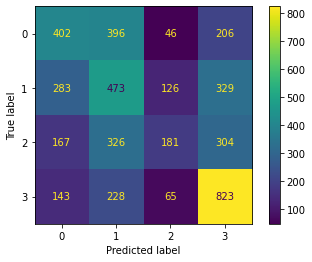

In [11]:
plot_confusion_matrix(m_xgb, X_val, y_val);

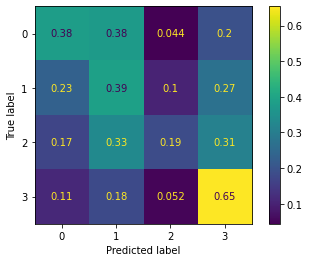

In [12]:
plot_confusion_matrix(m_xgb, X_val, y_val, normalize='true');

In [13]:
np.array(np.unique(pred, return_counts=True)).T

array([[   0,  995],
       [   1, 1423],
       [   2,  418],
       [   3, 1662]])

### Observation  
(+) The model predicts well on class 3  
(-) The model predicts poorly on class 2 (not many pets are predicted as class 2)  
(-) Since the predicted variable is ordinal (it has ordering), we expect some linear result. For example: prediction of class 0: predicted as class 0 > class 1 > class 3 > class 4 

In [14]:
def get_error(actual, pred):
    cm = confusion_matrix(actual, pred, normalize='true')
    return cm[0][1:].sum() + cm[1][2:].sum() + cm[2][3:]

In [15]:
get_error(y_val, pred)

array([1.30370385])